# 기본 설정

In [3]:
import random
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정


In [190]:
from google.colab import drive
drive.mount('/content/gdrive')
train= pd.read_csv('/content/gdrive/MyDrive/ML MODELING/공기압축기 이상판단/dataset/train_data.csv')
test= pd.read_csv('/content/gdrive/MyDrive/ML MODELING/공기압축기 이상판단/dataset/test_data.csv')
sam= pd.read_csv('/content/gdrive/MyDrive/ML MODELING/공기압축기 이상판단/dataset/answer_sample.csv')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [191]:
train.loc[train['type'] == 1,'HP'] = 20
train.loc[train['type'] == 2,'HP'] = 10
train.loc[train['type'] == 3,'HP'] = 50
train.loc[train['type'].isin([0,4,5,6,7]),'HP'] = 30

test.loc[test['type'] == 1,'HP'] = 20
test.loc[test['type'] == 2,'HP'] = 10
test.loc[test['type'] == 3,'HP'] = 50
test.loc[test['type'].isin([0,4,5,6,7]),'HP'] = 30

In [6]:
type0_train = train[train['HP'] == 30]
type1_train = train[train['HP'] == 20]
type2_train = train[train['HP'] == 10]
type3_train = train[train['HP'] == 50]

type0_test = test[test['HP'] == 30]
type1_test = test[test['HP'] == 20]
type2_test = test[test['HP'] == 10]
type3_test = test[test['HP'] == 50]

In [7]:
train.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,HP
count,2463.000000,2463.000000,2.463000e+03,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000
mean,2.128843,49.001137,7.000000e-01,27.490715,2372.576939,65.766707,3.452972,2.957369,28.014616
std,1.202328,8.725091,1.110448e-16,13.604597,687.870774,7.797152,1.576386,2.230113,10.964670
min,0.330000,32.030000,7.000000e-01,5.340000,1201.000000,50.360000,1.970000,0.000000,10.000000
25%,1.280000,41.600000,7.000000e-01,17.110000,1784.500000,59.150000,2.880000,1.000000,20.000000
50%,1.960000,48.980000,7.000000e-01,25.850000,2358.000000,65.640000,3.260000,3.000000,30.000000
75%,2.820000,56.355000,7.000000e-01,36.000000,2971.000000,72.275000,3.730000,5.000000,30.000000
max,6.220000,64.960000,7.000000e-01,72.000000,3564.000000,80.520000,21.870000,7.000000,50.000000


In [8]:
train_in = train[train['motor_vibe'] < 20]

In [9]:
len(train[train['motor_vibe'] > 20])

16

In [10]:
type0_train_in = train_in[train_in['HP'] == 30]
type1_train_in = train_in[train_in['HP'] == 20]
type2_train_in = train_in[train_in['HP'] == 10]
type3_train_in = train_in[train_in['HP'] == 50]

16개 row 삭제

In [106]:
id =test[test['out_pressure']!= 0.7].index

# PCA

In [12]:
def pca(train, test, x, y):
    train.columns = train.columns.astype(str)
    pca_ = PCA(n_components=2)
    train_pca = pca_.fit_transform(train)
    test_pca = pca_.transform(test)
    train_pca = pd.DataFrame(train_pca)
    test_pca = pd.DataFrame(test_pca)
    plt.figure(figsize = (10,4))
    plt.subplot(1,2,1)
    plt.scatter(train_pca[0], train_pca[1])
    plt.ylim(x,y)
    plt.title('train PCA scatter')
    plt.subplot(1,2,2)
    plt.scatter(test_pca[0], test_pca[1])
    plt.ylim(x,y)
    plt.title('test PCA scatter')
    plt.show()

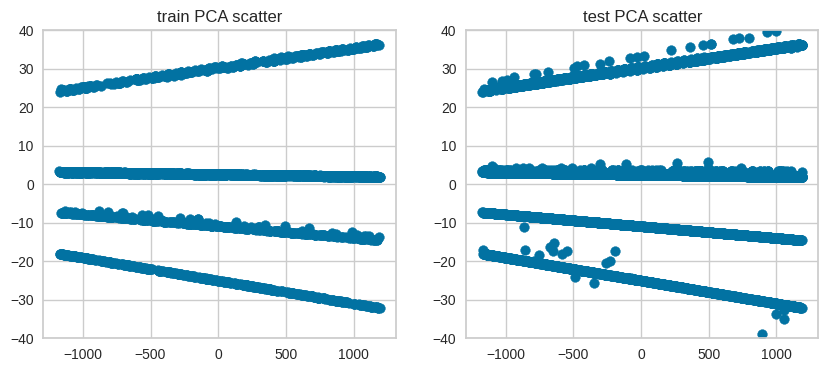

In [ ]:
pca(train, test, -40, 40)

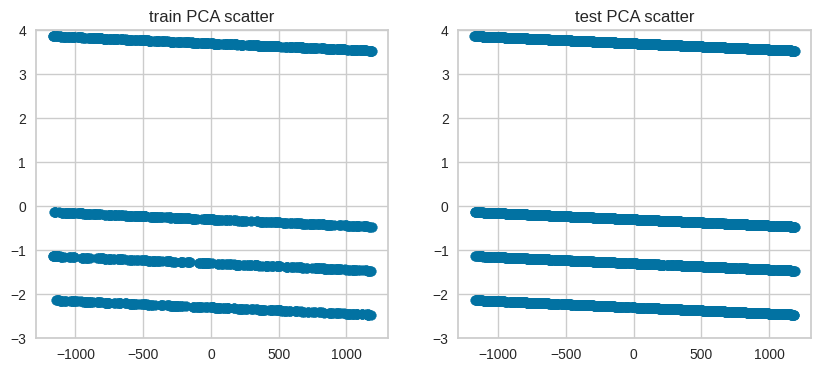

In [ ]:
pca(type0_train,type0_test, -3, 4)

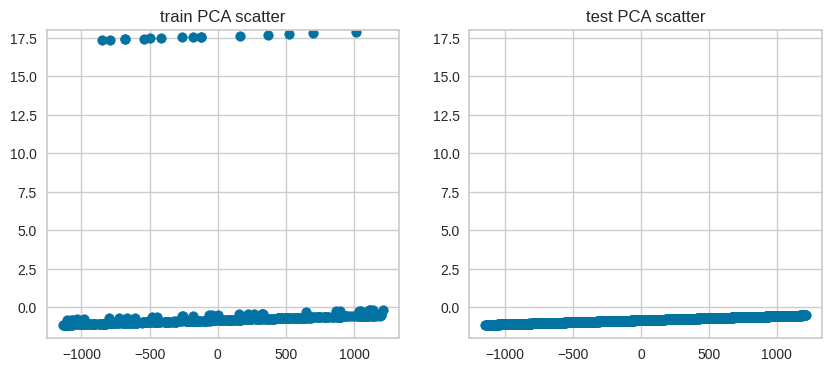

In [ ]:
pca(type1_train,type1_test , -2, 18)

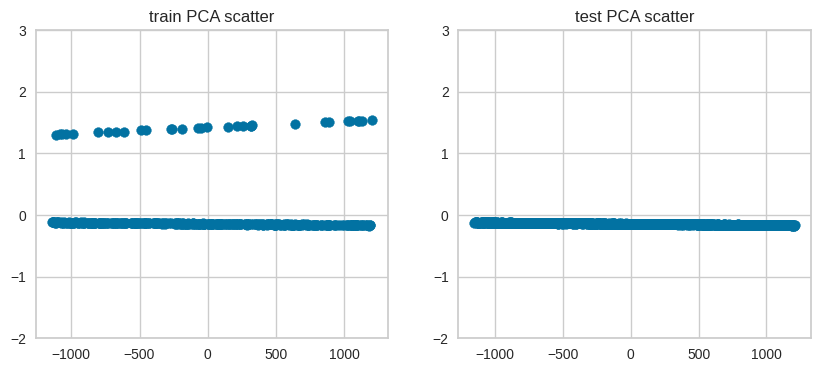

In [ ]:
pca(type1_train_in,type1_test , -2, 3)

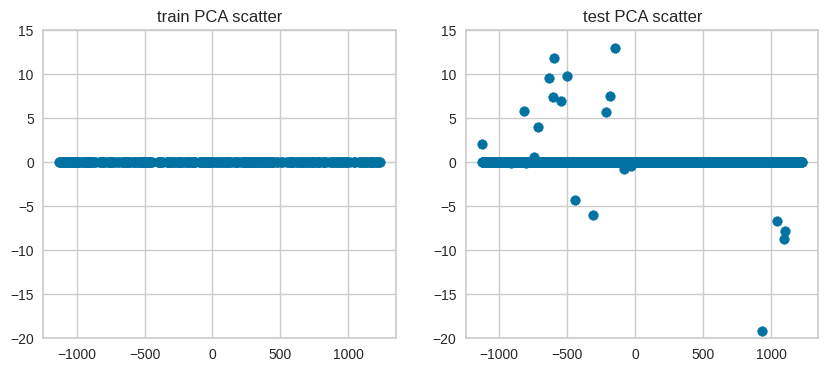

In [ ]:
pca(type2_train,type2_test, -20, 15)

In [ ]:
np.sum(abs(test2_pca[1]) > 0.01)

27

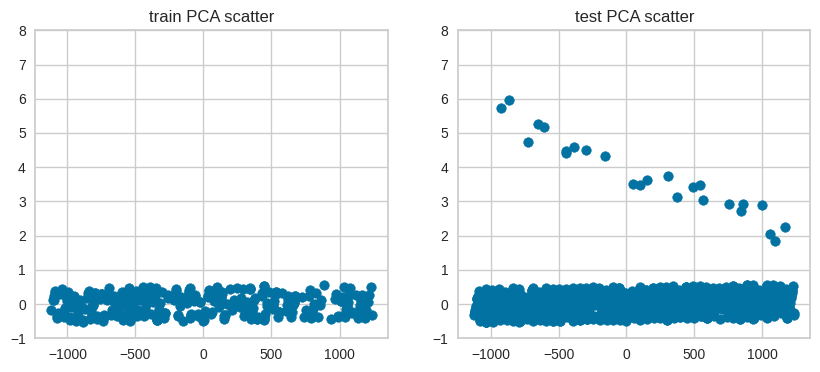

In [ ]:
pca(type3_train,type3_test, -1, 8)

In [ ]:
np.sum(abs(test3_pca[1]) > 1)

25

# 모델링

In [159]:
type0_train.columns = type0_train.columns.astype(str)
pca_ = PCA(n_components=2)
train0_pca = pca_.fit_transform(type0_train)
test0_pca = pca_.transform(type0_test)
train0_pca = pd.DataFrame(train0_pca)
test0_pca = pd.DataFrame(test0_pca)

type1_train.columns = type1_train.columns.astype(str)
pca_ = PCA(n_components=2)
train1_pca = pca_.fit_transform(type1_train)
test1_pca = pca_.transform(type1_test)
train1_pca = pd.DataFrame(train1_pca)
test1_pca = pd.DataFrame(test1_pca)

type2_train.columns = type2_train.columns.astype(str)
pca_ = PCA(n_components=2)
train2_pca = pca_.fit_transform(type2_train)
test2_pca = pca_.transform(type2_test)
train2_pca = pd.DataFrame(train2_pca)
test2_pca = pd.DataFrame(test2_pca)

type3_train.columns = type3_train.columns.astype(str)
pca_ = PCA(n_components=2)
train3_pca = pca_.fit_transform(type3_train)
test3_pca = pca_.transform(type3_test)
train3_pca = pd.DataFrame(train3_pca)
test3_pca = pd.DataFrame(test3_pca)


In [160]:
def ensem(train_pca, test_pca):
    # 모델 생성
    lo_clf = LocalOutlierFactor(novelty=True)
    if_clf = IsolationForest(n_estimators=50, max_samples=50, contamination=float(0.04),
                        max_features=1.0, bootstrap=False)
    svm_clf = OneClassSVM()

    # 데이터 학습
    lo_clf.fit(train_pca)
    if_clf.fit(train_pca)
    svm_clf.fit(train_pca)

    # 테스트 데이터에 대한 예측 수행
    lo_pred = lo_clf.predict(test_pca)
    if_pred = if_clf.predict(test_pca)
    svm_pred = svm_clf.predict(test_pca)

    # 각 모델의 예측 결과를 결합하여 최종 이상치 판단
    ensemble_pred = (lo_pred + if_pred + svm_pred) / 3

    pred = np.where(ensemble_pred < 0, 1, 0)
    test_pca['pred'] = pred
    print(test_pca['pred'].value_counts())

In [161]:
ensem(train0_pca, test0_pca)
ensem(train1_pca, test1_pca)
ensem(train2_pca, test2_pca)
ensem(train3_pca, test3_pca)

0    4100
1     166
Name: pred, dtype: int64
0    1069
1      38
Name: pred, dtype: int64
0    1040
1      58
Name: pred, dtype: int64
0    881
1     37
Name: pred, dtype: int64


In [162]:
test0_pca['index'] = type0_test.index
test1_pca['index'] = type1_test.index
test2_pca['index'] = type2_test.index
test3_pca['index'] = type3_test.index

In [163]:
test_p = pd.concat([test0_pca ,test1_pca])
test_p = pd.concat([test_p , test2_pca])
test_p = pd.concat([test_p , test3_pca])

test_p = test_p.sort_values('index').set_index('index')

In [150]:
test_p.loc[id]['pred']

4917    0
4918    0
4919    0
4920    0
4921    0
4922    0
4923    0
Name: pred, dtype: int64

In [214]:
test_p.loc[id, 'pred'] = 1

In [216]:
idx = test_p[test_p['pred'] == 1].index

In [215]:
test_p['pred'].value_counts()

0    7083
1     306
Name: pred, dtype: int64

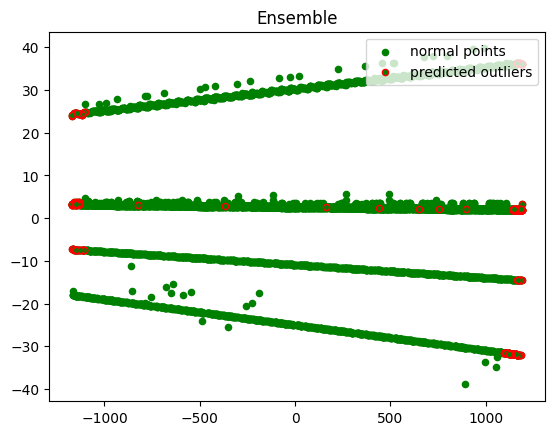

In [221]:
pca = PCA(2)
pca.fit(train)
res=pd.DataFrame(pca.transform(test))
Z = np.array(res)
plt.title("Ensemble")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[idx,0],res.iloc[idx,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [222]:
train

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,HP
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0,30.0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0,30.0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0,30.0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0,30.0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0,30.0
...,...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7,30.0
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7,30.0
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7,30.0
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7,30.0


In [223]:
train.columns = train.columns.astype(str)
pca_ = PCA(n_components=3)
train_pca = pca_.fit_transform(train)
test_pca = pca_.transform(test)


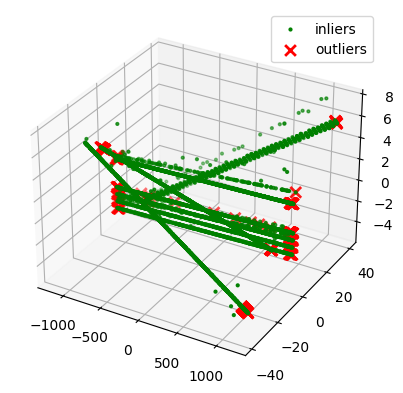

In [224]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(test_pca[:, 0], test_pca[:, 1], zs=test_pca[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(test_pca[idx,0],test_pca[idx,1], test_pca[idx,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()